In [2]:
import os, numpy as np, pandas, sklearn
import mido, rtmidi, rtmidi_
np.random.seed(333)
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

In [6]:
# local libs
import config
from data import data, midi
from utils import io

In [7]:
n: int = 8
context, x_train, labels = data.init(n)
print(x_train.shape)

Setting up params

 >> Context(max_t=10.0, dt=0.01, n_instances=1000, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

[INFO] :
 |  reading file: ../datasets/examples/01 16th Snare copy.mid
[INFO] :
 |  reading file: ../datasets/examples/01 16th Snare.mid
[INFO] :
 |  reading file: ../datasets/examples/01 8th Cym copy.mid
[INFO] :
 |  reading file: ../datasets/examples/01 8th Cym.mid
[INFO] :
 |  reading file: ../datasets/examples/01 8th Hat copy.mid
[INFO] :
 |  reading file: ../datasets/examples/01 8th Hat.mid
[INFO] :
 |  reading file: ../datasets/examples/02 8th Cym copy.mid
[INFO] :
 |  reading file: ../datasets/examples/02 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare copy.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym copy.mid' type 0, 1 tracks, 68 messages>, <midi file '../datasets/examples/

# Autoencoder
Input -> hidden layer -> output (=input)
Hidden layer has few dimension. Latent space of this layer should produce automatic categorization.

In [89]:
y_train = x_train
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:]
# output_length = y_train.shape[1]
# output_length = (y_train[0]).shape[0] # = length of an individual label
hidden_layer_length = 100
x_train.shape

(8, 1000, 127)

In [9]:
y_train.shape

(8, 1000, 127)

In [10]:
output_shape

(1000, 127)

In [57]:
y_train = x_train
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:]
# output_length = y_train.shape[1]
# output_length = (y_train[0]).shape[0] # = length of an individual label
hidden_layer_length = 100
timesteps = input_shape[0]
input_length = input_shape[1]
x_train.shape

(8, 1000, 127)

In [83]:
inputs = Input(shape=(timesteps, input_length))
x = inputs
x = Dense(127, activation='relu')(x)
encoded = LSTM(hidden_layer_length)(x)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_length, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
encoder.summary()
sequence_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1000, 127)         0         
_________________________________________________________________
dense_11 (Dense)             (None, 1000, 127)         16256     
_________________________________________________________________
lstm_23 (LSTM)               (None, 100)               91200     
Total params: 107,456
Trainable params: 107,456
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1000, 127)         0         
_________________________________________________________________
dense_11 (Dense)             (None, 1000, 127)         16256     
_________________________________________________________________
lstm

In [84]:
metrics = ['accuracy','mse','categorical_crossentropy']
loss = 'binary_crossentropy'
optimizer = 'adadelta'
# learning_rate = 0.001
# optimizer = optimizer = Adam(lr=learning_rate)
sequence_autoencoder.compile(optimizer=optimizer, loss=loss, metrics=metrics)
encoder.compile(optimizer='adadelta', loss=loss, metrics=metrics)

In [85]:
batch_size = 3
# n epochs = n iterations over all the training data
epochs = 15

In [86]:
sequence_autoencoder.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_model_dir)])
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
#           validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_model_dir)])

Train on 6 samples, validate on 2 samples
Epoch 1/15
6/6 [==============================] - 4s 745ms/step - loss: 0.4607 - acc: 0.9703 - mean_squared_error: 0.0324 - categorical_crossentropy: 25.2266 - val_loss: 0.8344 - val_acc: 0.9370 - val_mean_squared_error: 0.0676 - val_categorical_crossentropy: 102.4830
Epoch 2/15
6/6 [==============================] - 4s 587ms/step - loss: 0.3417 - acc: 0.9703 - mean_squared_error: 0.0311 - categorical_crossentropy: 35.4599 - val_loss: 0.7088 - val_acc: 0.9370 - val_mean_squared_error: 0.0642 - val_categorical_crossentropy: 86.8321
Epoch 3/15
6/6 [==============================] - 3s 576ms/step - loss: 0.2939 - acc: 0.9703 - mean_squared_error: 0.0293 - categorical_crossentropy: 39.1916 - val_loss: 0.5064 - val_acc: 0.9370 - val_mean_squared_error: 0.0594 - val_categorical_crossentropy: 61.2680
Epoch 4/15
6/6 [==============================] - 3s 580ms/step - loss: 0.1772 - acc: 0.9703 - mean_squared_error: 0.0264 - categorical_crossentropy: 43.

In [90]:
encode = encoder

In [91]:
result = encode.predict(x_train)
n = result.shape[0]
result.shape

(8, 100)

In [92]:
# scale/normalize data, based on features
# axis determines whether the data is scaled based on the 'global' features
# axis = 0: max per feature (between instances)
# axis = 1: max per instance (ignore features)
# e.g. np.arange(9).reshape(3,3).max(axis=0)

a = preprocessing.minmax_scale(np.arange(9).reshape(3,3), axis=0)
a

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


array([[0. , 0. , 0. ],
       [0.5, 0.5, 0.5],
       [1. , 1. , 1. ]])

In [93]:
a[:,1].mean()

0.5

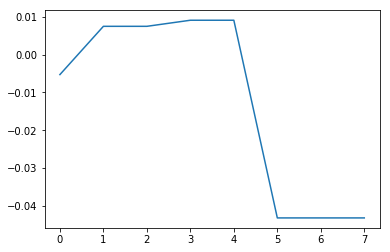

In [94]:
plt.plot(result[:,0])

In [95]:
normalized = preprocessing.normalize(result, axis=0)
# normalized = preprocessing.minmax_scale(result, axis=0)
# normalized = preprocessing.robust_scale(result, axis=0, quantile_range=(25, 75))
normalized[:,2]

array([-0.01546944, -0.17647123, -0.17647117, -0.26357594, -0.26357594,
       -0.51592374, -0.51592374, -0.51592374], dtype=float32)

In [96]:
result[:,2].mean()

-0.11813114

In [97]:
normalized[0,:].mean()

0.00053154706

In [98]:
data = normalized
data.shape

(8, 100)

In [99]:
data[:,2]

array([-0.01546944, -0.17647123, -0.17647117, -0.26357594, -0.26357594,
       -0.51592374, -0.51592374, -0.51592374], dtype=float32)

In [100]:
data[:2, 0]

array([-0.06837254,  0.09789184], dtype=float32)

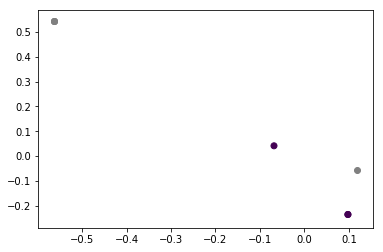

In [101]:
# plt.scatter(latent[:,0], latent[:,1], c=y_test[:num], alpha=0.1)
# plt.scatter(result[:,0],result[:,1])
plt.scatter(data[:3, 0], data[:3, 1], data='o', c=[0.4]*3)
plt.scatter(data[4:, 0], data[4:, 1], data='^', c=[0.5]*3)

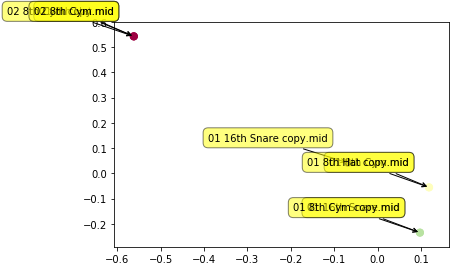

In [102]:
x_dim = 0
y_dim = 1
c_dim = 2
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    data[:, x_dim], data[:, y_dim], marker='o', c=data[:, c_dim], alpha=0.9, s=[50 for _ in range(n)],
    cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(labels, data[:, x_dim], data[:, y_dim]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

In [110]:
originals = result[0:2,]
new = originals.mean(axis=0)
arr = decode.predict(new)

NameError: name 'decode' is not defined

In [ ]:
midis = [midi.decode_track(context, track) for track in arr]